This is a venue search ranking model 
looking to predict rating according to search session_id_hashed
1. Data input (polars)
2. Data preprocessing
3. Preparing lgb Datasets
4. Model train
5. QA and aggregated evaluation

# Imports

In [1]:
import polars as pl
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from matplotlib import pyplot as plt
from typing import List
import pandas as pd
from sklearn.metrics import ndcg_score

# Parameters

In [2]:
label_column = "has_seen_venue_in_this_session"
pred_label = f"pred_{label_column}"
group_column = "session_id_hashed"
rank_column = "popularity"
rank_pos_column = "position_in_list"
predicted_rank_column = f"predicted_{rank_column}"
features = [
    'venue_id',
    'conversions_per_impression',
    'price_range',
    'rating',
    'popularity',
    'retention_rate',
    'session_id_hashed',
    'position_in_list',
    #  'has_seen_venue_in_this_session',
    #  'is_new_user',
    'is_from_order_again',
    'is_recommended']

# Utils

In [3]:
def convert_boolean_to_int(ranking_data):
    bool_cols = ranking_data.select(pl.col(pl.Boolean)).columns
    ranking_data = ranking_data.with_columns(
        [
            pl.col(column).cast(pl.Int8, strict=False).alias(column)
            for column in bool_cols
            ]
        )
    return ranking_data
def plot_lgb_report(lgb_model, evals_logs: dict, eval_at = [10, 20, 40]):
    for k in eval_at:
        fig, ax = plt.subplots(figsize=(12, 8))
        lgb.plot_metric(evals_logs, ax=ax, metric=f"ndcg@{k}")

        
    lgb.plot_importance(lgb_model, importance_type="gain", figsize=(14, 8))
    lgb.plot_importance(lgb_model, importance_type="split", figsize=(14, 8))
        
def qa_features(model: lgb, features: List[str]):
    feature_importance = {
        feature: importance
        for feature, importance in zip(
        model.feature_name(), model.feature_importance()
        )
    }
    print(feature_importance)
    used_features = [
        f for f in feature_importance
        if feature_importance[f] != 0
    ]
    dropped_features = [f for f in features if f not in used_features]
    print("-------------------------------------------------------")
    print("Used features: ")
    print(used_features)
    print("-------------------------------------------------------")
    print(
        f"passed {len(features)} "
        f"features and model used {len(used_features)} of them"
    )
    print("-------------------------------------------------------")
    print(f"these features were dropped: {dropped_features}")
    return used_features

def generate_predictions(
    test_set: pl.DataFrame, model: lgb, features_to_use: List[str]
) -> pd.DataFrame:
    test_set_pandas = test_set.sort(
        by=[group_column, rank_column], reverse=False
    ).to_pandas()
    test_set_pandas[features_to_use] = test_set_pandas[features_to_use].fillna(0)
    test_x = test_set_pandas[features_to_use]

    test_set_pandas[pred_label] = model.predict(test_x)
    test_set_pandas[predicted_rank_column] = (
        test_set_pandas.groupby(group_column)[pred_label]
        .rank(method="first", ascending=False)
    )
    return test_set_pandas

# Read data

In [4]:
%%time
sessions = pl.read_csv("../sessions.csv")
sessions = sessions.drop_nulls()
venues = pl.read_csv("../venues.csv")
venues = venues.drop_nulls()

CPU times: user 452 ms, sys: 594 ms, total: 1.05 s
Wall time: 368 ms


In [5]:
def add_purchase_indicator_for_session(sessions):
    sessions = sessions.join(sessions.groupby("session_id").agg(
        pl.col('purchased').max().alias('purchased_in_session')
    ).select('session_id','purchased_in_session'), on='session_id').sort('purchased_in_session')
    return sessions

# Join venue data with search data

In [6]:
ranking_data = sessions.join(venues, on="venue_id")
ranking_data = convert_boolean_to_int(ranking_data)
# hex_string = "0a21dde9-1495-417c-bb9d-9922b81f2e6a"


ranking_data = ranking_data.with_column(
    pl.col("session_id").str.replace("-","").alias("session_id_hashed").hash(seed=0)
)



/tmp/ipykernel_26930/3514575546.py:6: DeprecationWarning: `DataFrame.with_column` has been renamed; this redirect is temporary, please use `.with_columns` instead
  ranking_data = ranking_data.with_column(


# Split data into train, val and test

In [7]:
train_set, unseen_set = train_test_split(ranking_data, train_size=0.2, test_size=0.8)
val_set, test_set = train_test_split(unseen_set, train_size=0.2, test_size=0.8)

In [8]:
train_set.shape, val_set.shape, test_set.shape

((232757, 16), (186206, 16), (744825, 16))

In [9]:
train_set.sort(by=[group_column, rank_column], reverse=True)

,purchased,session_id,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed
i64,i8,str,i64,i64,i8,i8,i8,i8,i64,f64,i64,f64,f64,f64,u64
12732706,0,"""B6F51141-5CEA-...",150,131802517042376614,0,0,0,0,902,0.206568,2,9.0,18.994495,0.503247,18446336676963598362
12732621,0,"""B6F51141-5CEA-...",65,1990268925632192894,0,0,0,0,194,0.281423,3,8.8,16.555698,0.220719,18446336676963598362
12732736,0,"""B6F51141-5CEA-...",180,-8927711427237129003,0,0,0,0,931,0.267122,2,9.0,13.048912,0.226212,18446336676963598362
12732711,0,"""B6F51141-5CEA-...",155,2825547941213419305,0,0,0,1,469,0.09218,4,8.8,10.233847,0.189786,18446336676963598362
12732647,0,"""B6F51141-5CEA-...",91,7933826470430062978,0,0,0,0,473,0.175809,2,9.0,8.612243,0.189258,18446336676963598362
12732792,0,"""B6F51141-5CEA-...",236,8302321117389774572,0,0,0,0,925,0.354489,2,8.8,7.909118,0.342471,18446336676963598362
12732628,0,"""B6F51141-5CEA-...",72,-900459776699123906,0,0,0,0,182,0.33169,1,8.8,6.87328,0.370536,18446336676963598362
12732890,0,"""B6F51141-5CEA-...",334,4055135439123482652,0,0,0,0,521,0.141061,2,9.2,6.832611,0.151785,18446336676963598362
12732619,0,"""B6F51141-5CEA-...",63,-1292750757993165534,0,0,0,0,914,0.424906,2,8.8,5.934255,0.123214,18446336676963598362


# prepare datasets

In [10]:
train_set = train_set.sort(by=[group_column, rank_column], reverse=False)
train_set_group_sizes = (
    train_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

val_set = val_set.sort(by=[group_column, rank_column], reverse=False)
val_set_group_sizes = (
    val_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

In [11]:
%%time

train_y = train_set[[label_column]]
train_x = train_set[features]

val_y = val_set[[label_column]]
val_x = val_set[features]

test_x = test_set[features]

lgb_train_set = lgb.Dataset(
    train_x.to_pandas(),
    label=train_y.to_pandas(),
    group=train_set_group_sizes.to_numpy(),
    free_raw_data=True
).construct()

lgb_valid_set = lgb.Dataset(
    val_x.to_pandas(),
    label=val_y.to_pandas(),
    group=val_set_group_sizes.to_numpy(),
    reference=lgb_train_set,
    free_raw_data=True
).construct()

# some memory management
# del train_set
# del val_set
del train_y
del train_x

import gc

gc.collect()

CPU times: user 367 ms, sys: 80.8 ms, total: 448 ms
Wall time: 226 ms


/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


25

In [12]:
from collections import Counter
Counter(ranking_data[label_column].to_numpy())

Counter({1: 94046, 0: 1069742})

In [13]:
import os
data_path: str = "/tmp/lgb_train_set.binary"
n_rows: int = lgb_train_set.num_data()
n_features: int = lgb_train_set.num_feature()

print(f"Number of rows: {n_rows}")


print(f"Number of columns: {n_features}")
os.system(f"rm -rf {data_path}")
lgb_train_set.save_binary(data_path)
# Define the path to the binary file
 
import pathlib

# Create a Path object from a string
my_path = pathlib.Path(data_path)

# Print the Path object
print(my_path)

# Load the dataset from the binary file
dataset = lgb.Dataset(my_path, free_raw_data=False).construct()

# Print some information about the dataset
print(f"Number of rows: {dataset.num_data()}")
print(f"Number of columns: {dataset.num_feature()}")
assert dataset.num_data() == n_rows
assert dataset.num_feature() == n_features

Number of rows: 232757
Number of columns: 10
[LightGBM] [Info] Saving data to binary file /tmp/lgb_train_set.binary
/tmp/lgb_train_set.binary
[LightGBM] [Info] Load from binary file /tmp/lgb_train_set.binary
Number of rows: 232757
Number of columns: 10


# Train

In [14]:
lgb_params = {
    "objective": "lambdarank",
    "num_leaves": 100,
    "min_sum_hessian_in_leaf": 10,
    "metric": "ndcg",
    "ndcg_eval_at": [10, 20, 40],
    "learning_rate": 0.8,
    "force_row_wise": True,
    "num_iterations": 10,
}


In [15]:
%%time

evals_logs = {}
lgb_params
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train_set,
    valid_sets=[lgb_valid_set, lgb_train_set],
    valid_names=["val", "train"],
    verbose_eval=25,
    evals_result=evals_logs,
    early_stopping_rounds=25
)

[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 232757, number of used features: 10
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[10]	train's ndcg@10: 0.9995	train's ndcg@20: 0.9996	train's ndcg@40: 0.999664	val's ndcg@10: 0.997137	val's ndcg@20: 0.997394	val's ndcg@40: 0.997413
CPU times: user 521 ms, sys: 3.22 ms, total: 524 ms
Wall time: 119 ms


/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

# QA

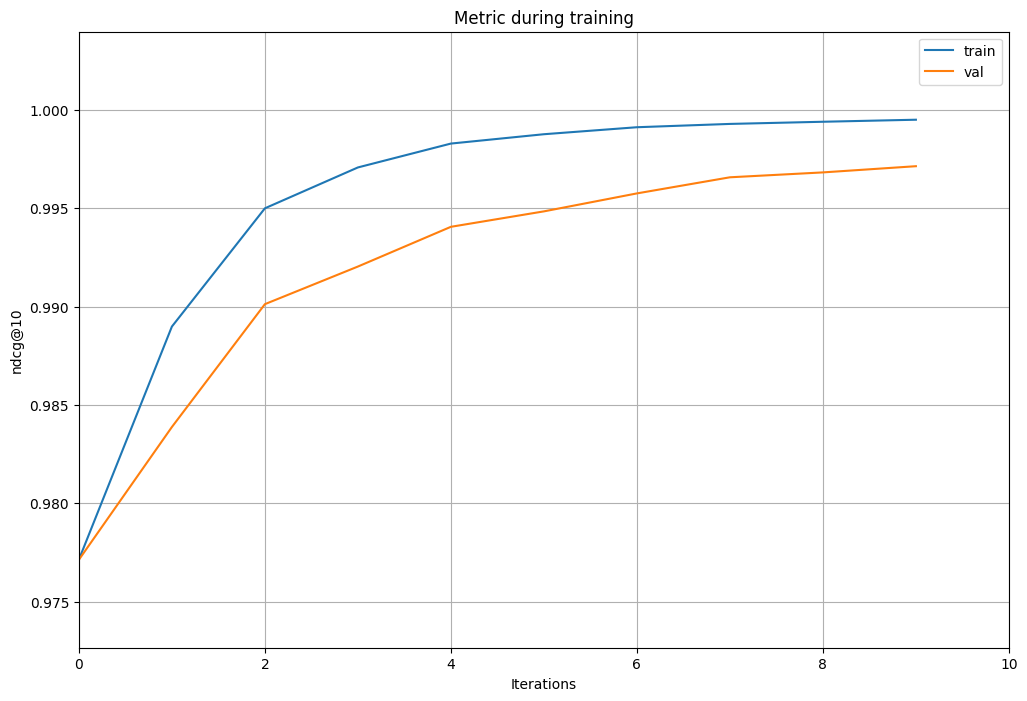

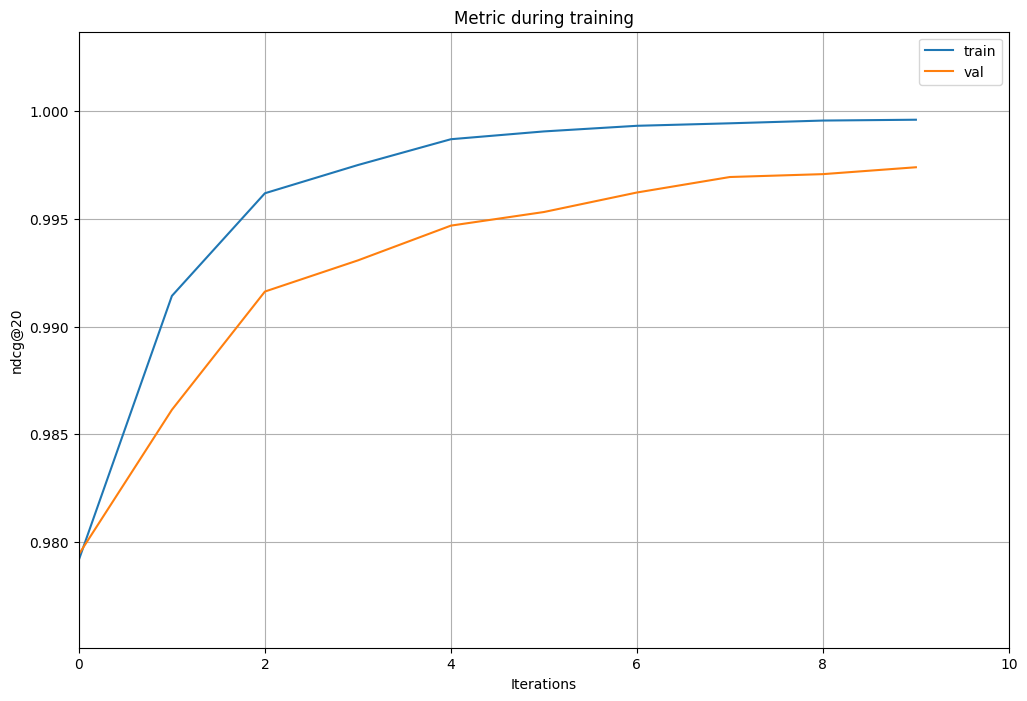

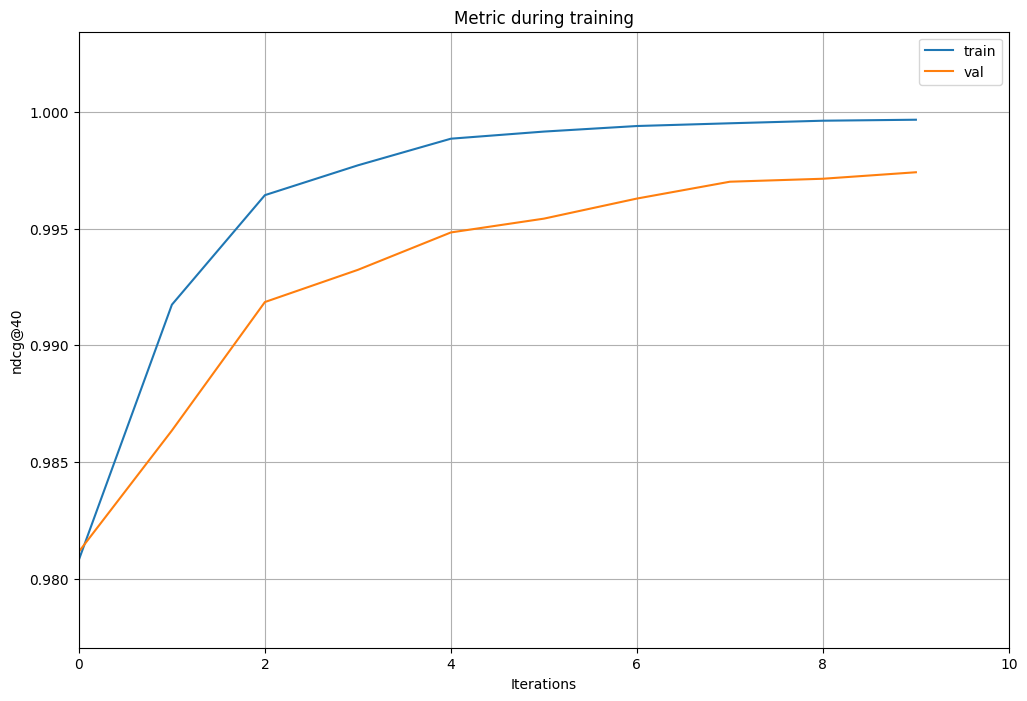

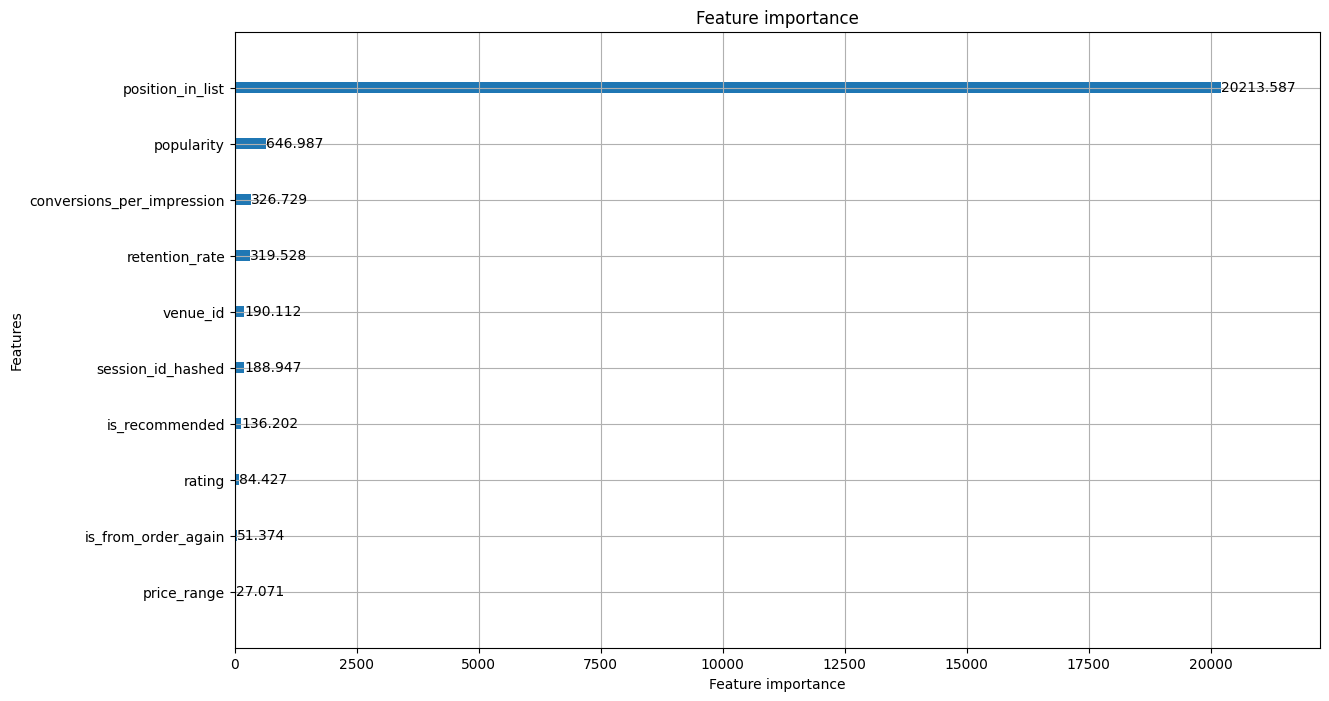

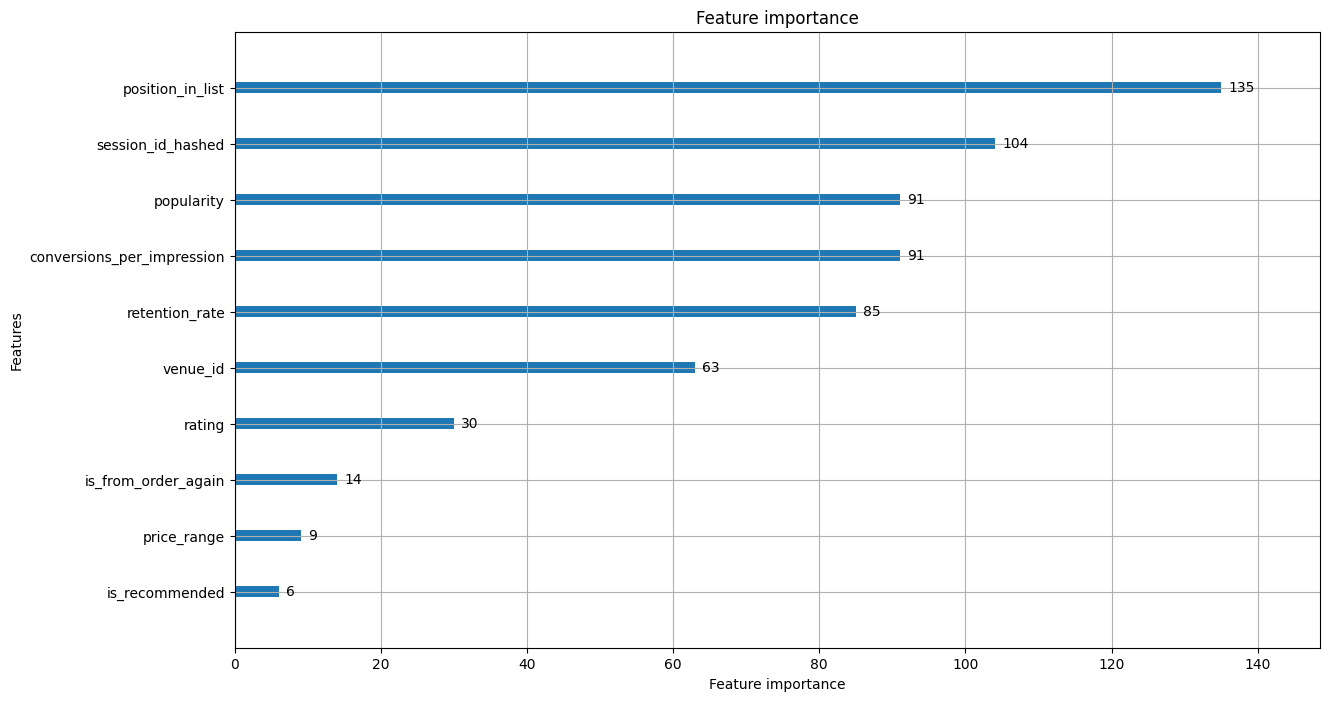

In [16]:
plot_lgb_report(lgb_model, evals_logs)

In [17]:
used_features = qa_features(lgb_model, features)

{'venue_id': 63, 'conversions_per_impression': 91, 'price_range': 9, 'rating': 30, 'popularity': 91, 'retention_rate': 85, 'session_id_hashed': 104, 'position_in_list': 135, 'is_from_order_again': 14, 'is_recommended': 6}
-------------------------------------------------------
Used features: 
['venue_id', 'conversions_per_impression', 'price_range', 'rating', 'popularity', 'retention_rate', 'session_id_hashed', 'position_in_list', 'is_from_order_again', 'is_recommended']
-------------------------------------------------------
passed 10 features and model used 10 of them
-------------------------------------------------------
these features were dropped: []


In [18]:
used_features

['venue_id',
 'conversions_per_impression',
 'price_range',
 'rating',
 'popularity',
 'retention_rate',
 'session_id_hashed',
 'position_in_list',
 'is_from_order_again',
 'is_recommended']

# save the trained model

In [19]:
%%time
lgb_model.save_model("/tmp/venues_ranking.pkl")

CPU times: user 3.05 ms, sys: 681 µs, total: 3.73 ms
Wall time: 1.15 ms


In [20]:
(
    ranking_data
    # .filter(pl.col("session_id_hashed")==2697534841382868)
    .sort(by=[group_column, rank_column], reverse=False)
    .groupby("session_id")
    .agg(
        pl.all().take([0,1, 2])
    )
    .explode("rating")
)

session_id,,purchased,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed
str,list[i64],list[i8],list[i64],list[i64],list[i8],list[i8],list[i8],list[i8],list[i64],list[f64],list[i64],f64,list[f64],list[f64],list[u64]
"""519be17e-d6fc-...","[8914589, 8914628, 8914684]","[0, 0, 0]","[56, 95, 151]","[472199130850792437, 3257242292074930225, 5976932403723417814]","[0, 0, 0]","[0, 0, 0]","[0, 0, 1]","[0, 0, 0]","[250, 398, 729]","[0.026087, 0.0, 0.05632]","[1, 2, 2]",9.0,"[0.0, 0.0, 0.0]","[1.0, 0.214286, 0.321429]","[14131258931050683168, 14131258931050683168, 14131258931050683168]"
"""519be17e-d6fc-...","[8914589, 8914628, 8914684]","[0, 0, 0]","[56, 95, 151]","[472199130850792437, 3257242292074930225, 5976932403723417814]","[0, 0, 0]","[0, 0, 0]","[0, 0, 1]","[0, 0, 0]","[250, 398, 729]","[0.026087, 0.0, 0.05632]","[1, 2, 2]",8.8,"[0.0, 0.0, 0.0]","[1.0, 0.214286, 0.321429]","[14131258931050683168, 14131258931050683168, 14131258931050683168]"
"""519be17e-d6fc-...","[8914589, 8914628, 8914684]","[0, 0, 0]","[56, 95, 151]","[472199130850792437, 3257242292074930225, 5976932403723417814]","[0, 0, 0]","[0, 0, 0]","[0, 0, 1]","[0, 0, 0]","[250, 398, 729]","[0.026087, 0.0, 0.05632]","[1, 2, 2]",9.0,"[0.0, 0.0, 0.0]","[1.0, 0.214286, 0.321429]","[14131258931050683168, 14131258931050683168, 14131258931050683168]"
"""a8d91c11-3e73-...","[14658077, 14658204, 14658301]","[0, 0, 0]","[107, 234, 331]","[1701525175334756094, -5505329314095346616, -3467116489823335298]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 499, 200]","[0.003067, 0.0, 0.039301]","[2, 2, 2]",9.0,"[0.0, 0.0, 0.0]","[0.3, 0.15, 0.272727]","[6977244325991590318, 6977244325991590318, 6977244325991590318]"
"""a8d91c11-3e73-...","[14658077, 14658204, 14658301]","[0, 0, 0]","[107, 234, 331]","[1701525175334756094, -5505329314095346616, -3467116489823335298]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 499, 200]","[0.003067, 0.0, 0.039301]","[2, 2, 2]",8.8,"[0.0, 0.0, 0.0]","[0.3, 0.15, 0.272727]","[6977244325991590318, 6977244325991590318, 6977244325991590318]"
"""a8d91c11-3e73-...","[14658077, 14658204, 14658301]","[0, 0, 0]","[107, 234, 331]","[1701525175334756094, -5505329314095346616, -3467116489823335298]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 499, 200]","[0.003067, 0.0, 0.039301]","[2, 2, 2]",8.6,"[0.0, 0.0, 0.0]","[0.3, 0.15, 0.272727]","[6977244325991590318, 6977244325991590318, 6977244325991590318]"
"""90e777c5-3161-...","[13963914, 13963925, 13963950]","[0, 0, 0]","[106, 117, 142]","[3257242292074930225, 472199130850792437, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[398, 250, 860]","[0.0, 0.026087, 0.007538]","[2, 1, 1]",8.8,"[0.0, 0.0, 0.0]","[0.214286, 1.0, 0.0]","[11903349321422978068, 11903349321422978068, 11903349321422978068]"
"""90e777c5-3161-...","[13963914, 13963925, 13963950]","[0, 0, 0]","[106, 117, 142]","[3257242292074930225, 472199130850792437, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[398, 250, 860]","[0.0, 0.026087, 0.007538]","[2, 1, 1]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 1.0, 0.0]","[11903349321422978068, 11903349321422978068, 11903349321422978068]"
"""90e777c5-3161-...","[13963914, 13963925, 13963950]","[0, 0, 0]","[106, 117, 142]","[3257242292074930225, 472199130850792437, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[398, 250, 860]","[0.0, 0.026087, 0.007538]","[2, 1, 1]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 1.0, 0.0]","[11903349321422978068, 11903349321422978068, 11903349321422978068]"


In [21]:
def calculate_ndcg_score(y_true: pl.Series, y_pred:pl.Series):
    return pl.Series([ndcg_score(y_true=y_true, y_score=y_pred)], dtype=pl.Float64)

In [22]:
predictions = generate_predictions(test_set, lgb_model, features_to_use=features)
predictions_pl = pl.DataFrame(predictions)

In [23]:
"has_seen_venue_in_this_session"

'has_seen_venue_in_this_session'

In [24]:
def drop_sessions_with_no_interactions(ranking_data):
    active_sessions = (
        ranking_data
        .filter(pl.col(label_column)==1)
        .select("session_id","position_in_list", "popularity").sort("session_id").groupby("session_id").count().sort("count")\
        .filter(pl.col("count")>1).select("session_id")
    )
    active_ranking_data = ranking_data.join(active_sessions, on="session_id")

    return active_ranking_data

In [25]:
active_ranking_data = drop_sessions_with_no_interactions(predictions_pl)

In [26]:
import numpy as np
import numpy as np
from sklearn.metrics import ndcg_score

def my_ndcg(y_true, y_pred):
    y_true = np.asarray([y_true])
    y_pred = np.asarray([y_pred])
    return ndcg_score(y_true=y_true, y_score = y_pred)
def my_relative_percentage_diff(baseline_value, model_value):
    baseline_vector = np.asarray(baseline_value)
    model_vector = np.asarray(model_value)
    print(baseline_vector)
    print(model_vector)
    return abs(baseline_vector-model_vector)/baseline_vector


In [27]:
%%time
baseline_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('baseline_ndcg')
    ])
)

CPU times: user 534 ms, sys: 10.1 ms, total: 544 ms
Wall time: 535 ms


In [28]:
%%time
model_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("predicted_popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('model_ndcg')
    ])
)

CPU times: user 579 ms, sys: 4.35 ms, total: 583 ms
Wall time: 573 ms


In [29]:
metric_columns = ["baseline_ndcg", "model_ndcg"]

In [30]:
metric_dataframe = predictions_pl.join(baseline_ndcg_per_sessions, on="session_id").join(model_ndcg_per_sessions, on="session_id")[ used_features + metric_columns].with_columns(
    [
        (pl.col("model_ndcg")-pl.col("baseline_ndcg")).alias("ndcg_diff")
    ]
).groupby("venue_id").mean()
metric_dataframe

venue_id,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed,position_in_list,is_from_order_again,is_recommended,baseline_ndcg,model_ndcg,ndcg_diff
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
8186682924953055136,0.067738,3.0,8.4,2.592504,0.263859,9.3360e18,117.80814,0.138081,0.023256,0.822956,0.978669,0.155712
798657896934031736,0.565854,1.0,8.2,1.36648,0.390532,9.2194e18,65.28866,0.226804,0.041237,0.808617,0.979512,0.170895
-7951050805344745744,0.095847,1.0,8.4,0.375117,0.28125,9.2622e18,121.558539,0.017186,0.021482,0.809317,0.978555,0.169238
7842758589917532536,0.251661,2.0,9.2,0.874456,0.401961,9.2963e18,211.404352,0.015413,0.021759,0.803879,0.979575,0.175695
2542674849763499656,0.046434,3.0,8.8,0.982192,0.259615,9.4156e18,218.537123,0.00464,0.025522,0.801062,0.980228,0.179167
-3918954707970063576,0.092207,2.0,9.2,3.507702,0.389672,9.3238e18,220.613126,0.052677,0.030225,0.804239,0.978695,0.174456
4541732343895239576,0.464459,1.0,8.8,13.378448,0.520992,9.8566e18,12.833333,0.333333,0.0,0.883423,0.975087,0.091664
6663247888677393976,0.121951,2.0,7.6,0.100583,0.068183,9.1990e18,282.651449,0.013169,0.026339,0.806103,0.980148,0.174045
-3434403621688310000,0.301948,3.0,8.8,0.88702,0.202702,9.1556e18,211.230769,0.030411,0.019678,0.805301,0.979319,0.174018


# calculate percentage increase of ndcg

In [31]:
metric_dataframe.with_columns(
    

    (abs(pl.col('baseline_ndcg') - pl.col("model_ndcg"))/pl.col('baseline_ndcg') * 100).alias('perc_increase_in_ndcg')
    
).groupby('venue_id').agg(
    pl.col('perc_increase_in_ndcg').mean()
).sort('perc_increase_in_ndcg', reverse=True)

venue_id,perc_increase_in_ndcg
i64,f64
-5574868108114075836,34.59714
8968794542286256815,29.26058
-2777513454983878087,29.117584
-4202398962129790175,28.512387
-8608196287932575311,27.197922
-2397771315306826730,26.522812
-625871812705516829,25.516566
-6991896213664680137,25.397973
6521448431149536288,25.328521


# explore predicted rankings on test data

In [32]:
venues_total = predictions_pl.select('venue_id').unique()
venues_total.shape[0]

1047

In [33]:
predictions_pl[features + [pred_label, predicted_rank_column]].filter(pl.col(pred_label)>0)

venue_id,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed,position_in_list,is_from_order_again,is_recommended,pred_has_seen_venue_in_this_session,predicted_popularity
i64,f64,i64,f64,f64,f64,u64,i64,i8,i8,f64,f64
8156589715251520207,0.196198,2,8.4,0.719713,0.33,2697534841382868,11,0,0,3.29959,9.0
-3621741757910659267,0.216077,2,9.0,1.014668,0.2403315,2697534841382868,1,1,0,7.561272,2.0
-3076644654800061823,0.070321,1,8.6,1.240613,0.2329545,2697534841382868,27,0,0,0.819125,16.0
-7018453133318028773,0.23731,3,9.0,1.487478,0.3090135,2697534841382868,3,1,0,6.047559,5.0
5788675179222482304,0.0751,2,8.4,1.714611,0.30693,2697534841382868,19,1,0,1.11981,14.0
6895638406641023853,0.357324,3,9.0,2.069597,0.3628425,2697534841382868,9,1,0,3.630651,8.0
-1559342796445485748,0.346895,1,8.4,2.298354,0.3984765,2697534841382868,0,1,0,8.929584,1.0
-5513786154158047947,0.289406,2,8.8,2.425594,0.258065,2697534841382868,29,1,0,0.246513,21.0
-284952526482148196,0.331709,2,8.8,2.929403,0.315534,2697534841382868,2,0,0,7.338286,3.0


In [34]:
positive_predictions = predictions_pl[features + [pred_label, predicted_rank_column]].filter(pl.col(pred_label)>0)

In [35]:
predictions_pl.groupby('venue_id').agg(
    [
        pl.col(rank_column).max().alias(f"max_{rank_column}"),
        pl.col(rank_column).min().alias(f"min_{rank_column}"),
        pl.col(rank_column).quantile(0.8).alias(f"q80_{rank_column}"),
        pl.col(predicted_rank_column).max().alias(f"max_{predicted_rank_column}"),
        pl.col(predicted_rank_column).min().alias(f"min_{predicted_rank_column}"),
        pl.col(predicted_rank_column).quantile(0.8).alias(f"q80_{predicted_rank_column}")]
)

venue_id,max_popularity,min_popularity,q80_popularity,max_predicted_popularity,min_predicted_popularity,q80_predicted_popularity
i64,f64,f64,f64,f64,f64,f64
2356772020720540088,0.183156,0.183156,0.183156,1183.0,1.0,268.0
-8513879466791027048,0.641626,0.641626,0.641626,1301.0,13.0,273.0
6532681182411690288,1.678649,1.678649,1.678649,866.0,1.0,177.0
3989452688348424400,0.249366,0.249366,0.249366,1220.0,7.0,204.0
-692123557610643528,7.88356,7.88356,7.88356,106.0,7.0,66.0
-5064330078514031600,4.899344,4.899344,4.899344,79.0,1.0,30.0
-5505329314095346616,0.0,0.0,0.0,1133.0,45.0,260.0
-6477717598905558400,0.366479,0.366479,0.366479,70.0,1.0,32.0
-3918954707970063576,3.507702,3.507702,3.507702,926.0,1.0,204.0


In [36]:
positive_predictions.groupby('venue_id').agg(
    [
        pl.col(rank_column).max().alias(f"max_{rank_column}"),
        pl.col(rank_column).min().alias(f"min_{rank_column}"),
        pl.col(rank_column).quantile(0.8).alias(f"q80_{rank_column}"),
        pl.col(predicted_rank_column).max().alias(f"max_{predicted_rank_column}"),
        pl.col(predicted_rank_column).min().alias(f"min_{predicted_rank_column}"),
        pl.col(predicted_rank_column).quantile(0.8).alias(f"q80_{predicted_rank_column}")]
)

venue_id,max_popularity,min_popularity,q80_popularity,max_predicted_popularity,min_predicted_popularity,q80_predicted_popularity
i64,f64,f64,f64,f64,f64,f64
-1249386614889987096,0.293107,0.293107,0.293107,22.0,4.0,17.0
-5064330078514031600,4.899344,4.899344,4.899344,22.0,1.0,15.0
1541306607799916328,0.289876,0.289876,0.289876,20.0,2.0,17.0
6532681182411690288,1.678649,1.678649,1.678649,22.0,1.0,16.0
-1498717153989572032,1.00496,1.00496,1.00496,43.0,1.0,15.0
-115775337990273376,27.015055,27.015055,27.015055,20.0,6.0,20.0
-6007126584927194216,17.615985,17.615985,17.615985,18.0,1.0,14.0
938528933528631760,0.227783,0.227783,0.227783,19.0,1.0,10.0
-7906996811450282616,1.635678,1.635678,1.635678,54.0,2.0,19.0


# percentage of venues where we predict popularity

In [37]:
926/1043 * 100

88.7823585810163

In [38]:
predictions_pl[features + [pred_label, predicted_rank_column]].filter(pl.col(pred_label)>0).select("venue_id", predicted_rank_column).unique()

venue_id,predicted_popularity
i64,f64
8156589715251520207,9.0
-3621741757910659267,2.0
-3076644654800061823,16.0
-7018453133318028773,5.0
5788675179222482304,14.0
6895638406641023853,8.0
-1559342796445485748,1.0
-5513786154158047947,21.0
-284952526482148196,3.0
